In [1]:
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
std = StandardScaler()
from datetime import date
import holidays
KR_holidays = holidays.KR()
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, BatchNormalization, GRU
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
from datetime import datetime
import datetime as dt
from tqdm import tqdm
from time import sleep
from scipy import stats


In [2]:
root_path = '/Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset'

In [3]:
df = pd.read_csv(root_path+'/train/machine-1-1.txt')
with open(root_path+'/interpretation_label/machine-1-1.txt', 'r') as file:
    anomaly_events = file.readlines()

In [4]:
# Renaming the columns for clarity
column_names = [f"Dimension {i+1}" for i in range(38)]
df.columns = column_names

# Re-display the first few rows with updated column names
df.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 29,Dimension 30,Dimension 31,Dimension 32,Dimension 33,Dimension 34,Dimension 35,Dimension 36,Dimension 37,Dimension 38
0,0.043011,0.048729,0.033445,0.025552,0.0,0.915385,0.344633,0.0,0.019160,0.001722,...,0.0,0.004298,0.030041,0.028821,0.0,0.000045,0.035763,0.035833,0.0,0.0
1,0.043011,0.034958,0.032330,0.025552,0.0,0.915385,0.344633,0.0,0.020011,0.000122,...,0.0,0.004298,0.026248,0.021101,0.0,0.000045,0.033012,0.033082,0.0,0.0
2,0.032258,0.028602,0.030100,0.024390,0.0,0.912821,0.342750,0.0,0.021289,0.000000,...,0.0,0.004298,0.030169,0.025733,0.0,0.000022,0.035112,0.035182,0.0,0.0
3,0.032258,0.019068,0.026756,0.023229,0.0,0.912821,0.342750,0.0,0.018734,0.000000,...,0.0,0.004298,0.027240,0.022645,0.0,0.000034,0.033447,0.033517,0.0,0.0
4,0.043011,0.007415,0.021182,0.022067,0.0,0.917949,0.343691,0.0,0.019160,0.000000,...,0.0,0.004298,0.030217,0.022645,0.0,0.000034,0.034171,0.034241,0.0,0.0


In [5]:

# The anomaly information as interpreted from the TXT file
anomaly_info = """
15849-16368:1,9,10,12,13,14,15
16963-17517:1,2,3,4,6,7,9,10,11,12,13,14,15,16,19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,36
18071-18528:1,2,9,10,12,13,14,15
19367-20088:1,2,3,4,9,10,11,12,13,14,15,16,25,28
20786-21195:1,9,10,12,13,14,15
24679-24682:9,13,14,15
26114-26116:9,13,14,15
27554-27556:9,13,14,15
"""

# Parse the anomaly information
anomalies = []
for line in anomaly_info.strip().split('\n'):
    steps, dimensions = line.split(':')
    start_step, end_step = map(int, steps.split('-'))
    dimensions = list(map(int, dimensions.split(',')))
    for step in range(start_step, end_step + 1):
        anomalies.append({'step': step, 'dimensions': dimensions})

# Convert to DataFrame for easier manipulation
anomalies_df = pd.DataFrame(anomalies)

# Add a column to the original dataframe to label anomalies
df['Anomaly'] = 0  # Assume no anomaly initially
for index, row in anomalies_df.iterrows():
    df.loc[row['step'] - 1, 'Anomaly'] = 1  # -1 to adjust for 0-based indexing in the dataframe

# Verify by displaying rows where anomaly is labeled
df[df['Anomaly'] == 1].head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 30,Dimension 31,Dimension 32,Dimension 33,Dimension 34,Dimension 35,Dimension 36,Dimension 37,Dimension 38,Anomaly
15848,0.075269,0.062500,0.078038,0.075494,0.0,0.905128,0.310734,0.0,0.019728,0.000000,...,0.005731,0.062242,0.046320,0.000000,0.000034,0.065084,0.065079,0.0,0.0,1
15849,0.064516,0.088983,0.084727,0.077816,0.0,0.910256,0.310734,0.0,0.020011,0.000122,...,0.005731,0.060577,0.051981,0.000386,0.000045,0.066821,0.066889,0.0,0.0,1
15850,0.075269,0.169492,0.101449,0.083624,0.0,0.905128,0.308851,0.0,0.019302,0.000000,...,0.005731,0.061922,0.042717,0.000386,0.000011,0.064142,0.064210,0.0,0.0,1
15851,0.064516,0.076271,0.086957,0.078978,0.0,0.905128,0.307910,0.0,0.013767,0.000000,...,0.005731,0.060641,0.052496,0.000386,0.000034,0.066894,0.066889,0.0,0.0,1
15852,0.053763,0.072034,0.081382,0.077816,0.0,0.910256,0.308851,0.0,0.020721,0.000000,...,0.005731,0.052879,0.039115,0.000000,0.000022,0.060450,0.060518,0.0,0.0,1


In [6]:
df.columns

Index(['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4',
       'Dimension 5', 'Dimension 6', 'Dimension 7', 'Dimension 8',
       'Dimension 9', 'Dimension 10', 'Dimension 11', 'Dimension 12',
       'Dimension 13', 'Dimension 14', 'Dimension 15', 'Dimension 16',
       'Dimension 17', 'Dimension 18', 'Dimension 19', 'Dimension 20',
       'Dimension 21', 'Dimension 22', 'Dimension 23', 'Dimension 24',
       'Dimension 25', 'Dimension 26', 'Dimension 27', 'Dimension 28',
       'Dimension 29', 'Dimension 30', 'Dimension 31', 'Dimension 32',
       'Dimension 33', 'Dimension 34', 'Dimension 35', 'Dimension 36',
       'Dimension 37', 'Dimension 38', 'Anomaly'],
      dtype='object')

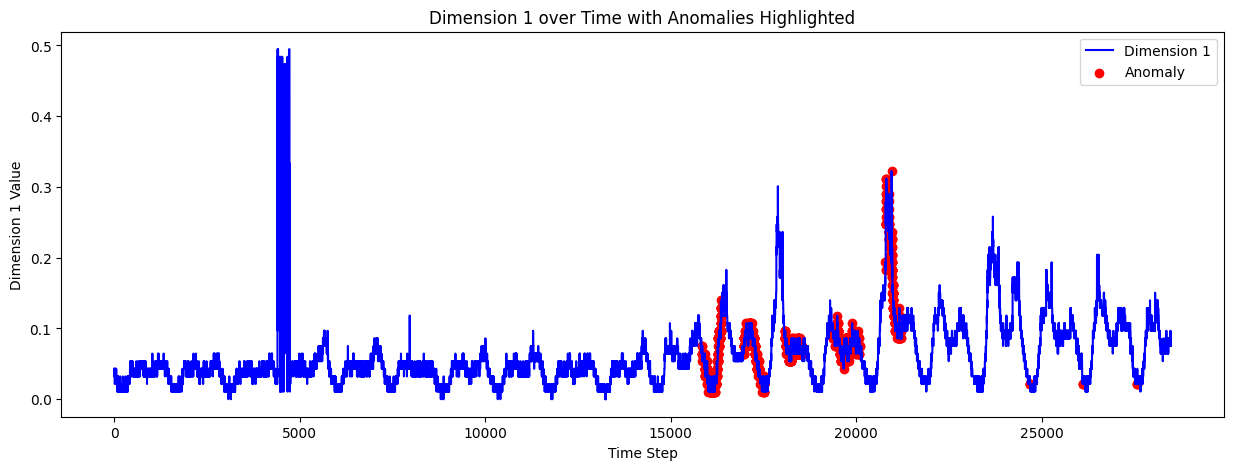

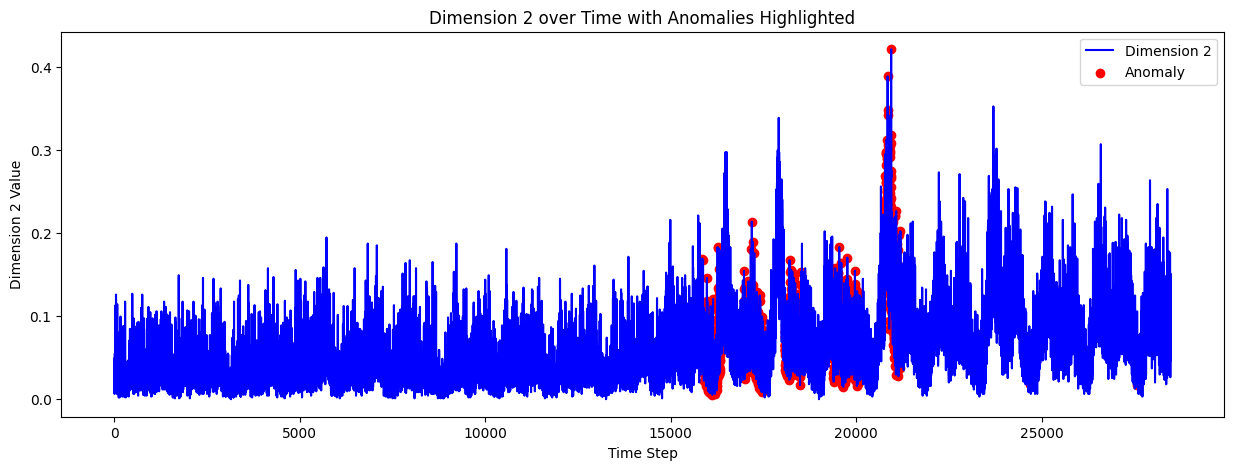

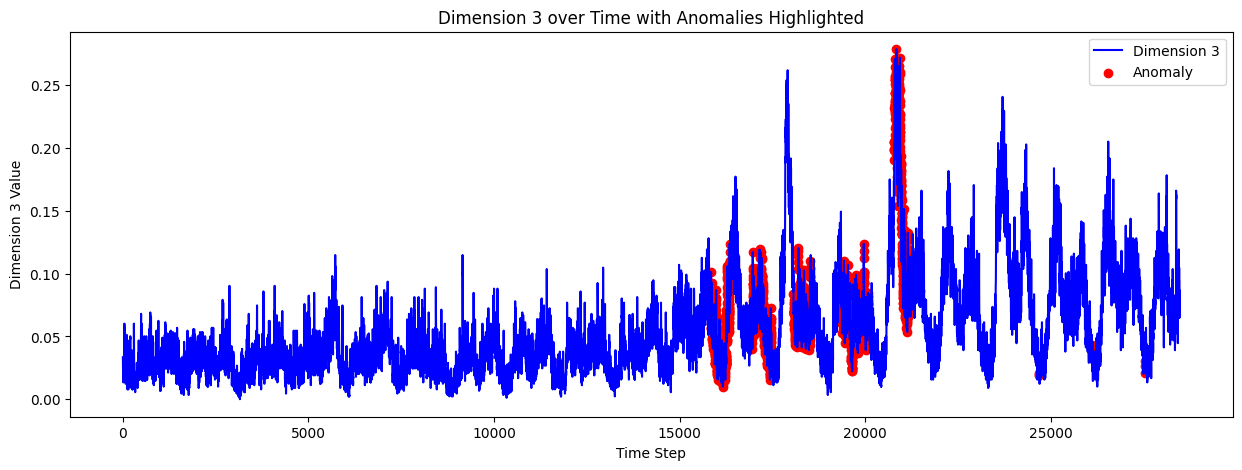

In [7]:
import matplotlib.pyplot as plt

# Function to plot a given dimension with anomalies highlighted
def plot_dimension_with_anomalies(dimension_number):
    plt.figure(figsize=(15, 5))
    plt.plot(df[f"Dimension {dimension_number}"], label=f"Dimension {dimension_number}", color='blue')
    
    # Highlighting anomalies
    anomalies = df[df['Anomaly'] == 1]
    plt.scatter(anomalies.index, anomalies[f"Dimension {dimension_number}"], color='red', label='Anomaly')
    
    plt.title(f"Dimension {dimension_number} over Time with Anomalies Highlighted")
    plt.xlabel("Time Step")
    plt.ylabel(f"Dimension {dimension_number} Value")
    plt.legend()
    plt.show()

# Plotting the first three dimensions as an example
for i in range(1, 4):
    plot_dimension_with_anomalies(i)

In [8]:
len(df)

28478

In [25]:
past_history = 1
future_target = 1
STEP = 1
predict_col = 0

In [26]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index, target_size):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [27]:

def preprocessing(data, past_history, future_target, STEP, predict_col):

    TRAIN_SPLIT = int(len(data)* 0.8)
    #TRAIN_SPLIT = int(len(data)-len(df2))
    
    #피쳐
    features_considered = ['Dimension 2', 'Dimension 3', 'Dimension 4', 'Dimension 5', 'Dimension 6']
    features = data[features_considered]
    #features.index = data['date']
    #features.plot(subplots=True)
    F_dataset = features.values
    print(np.shape(F_dataset))
    F_scaler.fit(F_dataset)
    F_dataset = F_scaler.transform(F_dataset)
    print(np.shape(F_dataset))
    F_dataset = F_dataset.reshape(-1, len(features_considered))
    print(np.shape(F_dataset))
    print(F_dataset)

    #타겟
    features_considered = ['Dimension 1']
    features = data[features_considered]
    T_dataset = features.values
    T_scaler.fit(T_dataset)
    T_dataset = T_scaler.transform(T_dataset)
    T_dataset = T_dataset.reshape(-1, 1)
    print(np.shape(T_dataset))
    print(T_dataset)

    dataset = np.concatenate((T_dataset, F_dataset), axis=1)
    print(dataset)
    x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, predict_col], 0, TRAIN_SPLIT, past_history, future_target, STEP)
    x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, predict_col], TRAIN_SPLIT, None, past_history, future_target, STEP)

    return x_train_multi, y_train_multi, x_val_multi, y_val_multi


In [28]:
F_scaler = MinMaxScaler()
T_scaler = MinMaxScaler()
x_train_multi, y_train_multi, x_val_multi, y_val_multi = preprocessing(df, past_history, future_target, STEP, predict_col)

(28478, 5)
(28478, 5)
(28478, 5)
[[0.11557838 0.12000057 0.10185314 0.         0.915385  ]
 [0.08291549 0.11599996 0.10185314 0.         0.915385  ]
 [0.06783995 0.10799872 0.09722128 0.         0.912821  ]
 ...
 [0.15577904 0.26400126 0.30555544 0.         0.935897  ]
 [0.13316572 0.24399818 0.29629571 0.         0.933333  ]
 [0.1934679  0.26000065 0.30092757 0.         0.933333  ]]
(28478, 1)
[[0.08695696]
 [0.08695696]
 [0.06521722]
 ...
 [0.17391392]
 [0.17391392]
 [0.15217418]]
[[0.08695696 0.11557838 0.12000057 0.10185314 0.         0.915385  ]
 [0.08695696 0.08291549 0.11599996 0.10185314 0.         0.915385  ]
 [0.06521722 0.06783995 0.10799872 0.09722128 0.         0.912821  ]
 ...
 [0.17391392 0.15577904 0.26400126 0.30555544 0.         0.935897  ]
 [0.17391392 0.13316572 0.24399818 0.29629571 0.         0.933333  ]
 [0.15217418 0.1934679  0.26000065 0.30092757 0.         0.933333  ]]


In [29]:
np.shape(x_train_multi)

(22781, 1, 6)

In [30]:
BATCH_SIZE = 32
BUFFER_SIZE = 10
EPOCHS = 10
EVALUATION_INTERVAL = len(x_train_multi)//BATCH_SIZE
VALIDATION_STEPS = len(x_val_multi)//BATCH_SIZE # if you have validation data 

In [31]:
def create_time_steps(length):
  return range(-length, 0)

In [32]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  
  plt.plot(num_in, np.array(history[:, predict_col]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'g',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [33]:
from torch import nn, optim
import torch
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [34]:
epochs = 50

validation = 0.1

In [35]:
x_val_multi.shape

(5694, 1, 6)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='mse', min_delta=0.0001, patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\
DATA_OUT_PATH = '/Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUT'
model_name = 'two_lstm'
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='mse', verbose=1, save_best_only=True, save_weights_only=True)

/Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm -- Folder already exists 



In [37]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Attention
from keras.layers import concatenate

In [38]:
adam = optimizers.Adam(lr = 0.001)

In [73]:
input1 = Input(shape=x_train_multi.shape[-2:])
dense1 = Conv1D(filters=16, kernel_size = 1, activation='relu')(input1)
dense1_2 = Conv1D(filters=32, kernel_size = 1, activation='relu')(dense1)
dense1_3 = Conv1D(filters= 64, kernel_size = 1, activation='relu')(dense1_2)
dense1_4 = Flatten()(dense1_3)
#dense1_5 = BatchNormalization()(dense1_4)

input2 = Input(shape=x_train_multi.shape[-2:])
dense2 = LSTM(16, return_sequences=True)(input2)
dense2_2 = LSTM(32, return_sequences=True)(dense2)
dense2_3 = LSTM(64, return_sequences=False)(dense2_2)
#dense2_4 = BatchNormalization()(dense2_3)

from keras.layers import concatenate

merge1 = concatenate([dense1_4, dense2_3])

#drop_out = Dropout(0.3)(merge1)

#model1 = BatchNormalization()(merge1)
#model3 = Flatten()(model1)
model2 = Dense(64)(merge1)
model3 = Dense(32)(model2)
output = Dense(6)(model3)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# 생성자(디코더) 모델
def build_generator(latent_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(9*9*64, input_dim=latent_dim, activation='relu'))
    model.add(layers.Reshape((9, 9, 64)))
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(6, kernel_size=3, strides=1, padding='same', activation='sigmoid'))
    return model

# 판별자(인코더) 모델
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(72, 6, 1), activation='relu'))
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# GAN 모델 생성
def build_gan(generator, discriminator):
    discriminator.trainable = False  # 판별자는 학습되지 않도록 설정

    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# 모델 생성 및 컴파일
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

discriminator.compile(optimizer='adam', loss='binary_crossentropy')
gan.compile(optimizer='adam', loss='binary_crossentropy')

# 가짜 데이터 생성
def generate_fake_data(generator, latent_dim, num_samples):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    fake_data = generator.predict(noise)
    return fake_data

# 학습 데이터 전처리
# 예제에서는 입력 데이터의 형태를 변환하여 (14000, 72, 6, 1)로 만들었습니다.
# 만약 입력 데이터가 이미 4D 텐서 형태인 경우 이 단계는 생략할 수 있습니다.
def preprocess_real_data(x):
    x = np.expand_dims(x, axis=-1)
    return x



# 학습
epochs = 50
batch_size = 128
batch_count = x_train_multi.shape[0] // batch_size

for epoch in range(epochs):
    for batch in range(batch_count):
        # 진짜 데이터 선택
        real_images = x_train_multi[batch * batch_size: (batch + 1) * batch_size]
        
        # 랜덤한 잠재 공간에서 노이즈 샘플링 및 가짜 데이터 생성
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_images = generator.predict(noise)
        
        # 판별자 훈련
        x = np.concatenate((real_images, generated_images))
        y = np.zeros(2 * batch_size)
        y[:batch_size] = 1
        discriminator_loss = discriminator.train_on_batch(x, y)
        
        # 생성자 훈련
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        y = np.ones(batch_size)
        generator_loss = gan.train_on_batch(noise, y)
        
    # 각 에포크 후에 손실 출력
    print(f"Epoch {epoch+1}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")

# 결과 시각화
noise = np.random.normal(0, 1, (100, latent_dim))
generated_images = generator.predict(noise)

plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i].reshape(72, 6), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()


ValueError: Exception encountered when calling layer "sequential_10" (type Sequential).

Input 0 of layer "conv2d_6" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 36, 36, 6)

Call arguments received by layer "sequential_10" (type Sequential):
  • inputs=tf.Tensor(shape=(None, 36, 36, 6), dtype=float32)
  • training=None
  • mask=None

In [74]:
model = Model(inputs = [input1, input2], outputs = output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 24, 6)]      0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 24, 16)       112         ['input_5[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 24, 6)]      0           []                               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 24, 32)       544         ['conv1d_6[0][0]']               
                                                                                            

In [75]:
model.compile(optimizer=adam, loss='mse', metrics=['mse'])

model_history=model.fit([x_train_multi, x_train_multi], y_train_multi, epochs=20,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          #validation_data=val_data_multi,
                                          validation_steps=VALIDATION_STEPS, 
                                          batch_size = BATCH_SIZE, callbacks=[earlystop_callback, cp_callback], validation_data=([x_val_multi, x_val_multi], y_val_multi))


Epoch 1/20


2024-04-05 13:36:35.334219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:36:35.689677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:36:35.904790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:36:36.068632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:36:36.621013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:36:37.123993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:36:37.489714: I tensorflow/core/grappler/optimizers/cust

118/118 [==============================] - ETA: 0s - loss: 0.0054 - mse: 0.0054

2024-04-05 13:36:42.259461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:36:42.385238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:36:42.523754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:36:42.653618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: mse improved from inf to 0.00539, saving model to /Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm/weights.h5
118/118 [==============================] - 9s 46ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 8.0003e-04 - val_mse: 8.0003e-04
Epoch 2/20
117/118 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.0019
Epoch 2: mse improved from 0.00539 to 0.00190, saving model to /Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm/weights.h5
118/118 [==============================] - 6s 37ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 6.7503e-04 - val_mse: 6.7503e-04
Epoch 3/20
117/118 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0018
Epoch 3: mse improved from 0.00190 to 0.00180, saving model to /Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm/weights.h5
118/118 [==============================] - 4s 37ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 5.4202e-04 - val_mse: 5.4202e-04

In [76]:
mse = model.evaluate([x_val_multi, x_val_multi], y_val_multi, batch_size = 1)

945/945 [==============================] - 14s 14ms/step - loss: 4.9320e-04 - mse: 4.9320e-04


In [77]:
y_predict = model.predict([x_val_multi[0:1000], x_val_multi[0:1000]])
#for i in tqdm(range(len(y_predict))):
#    print(y_val_multi[i], y_predict[i])

2024-04-05 13:37:25.985656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:37:26.106129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:37:26.258953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-05 13:37:26.390915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 25ms/step


In [78]:
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()
from sklearn.metrics import r2_score
def RMSE(real, pred):
    return np.sqrt((1/len(real))* np.sum((real-pred)**2))

In [82]:
answer_list = []
predict_list = []
for i in range(len(x_val_multi)):
    x = x_val_multi[i].reshape((-1, 24, 6))
    answer = y_val_multi[i]
    
    predict = model.predict([x, x])[0]
    answer_list.append(answer)
    predict_list.append(predict)

1/1 [==============================] - 0s 21ms/step


In [83]:
answer = np.reshape(answer_list, (-1, 1))
predict = np.reshape(predict_list, (-1, 1)) 

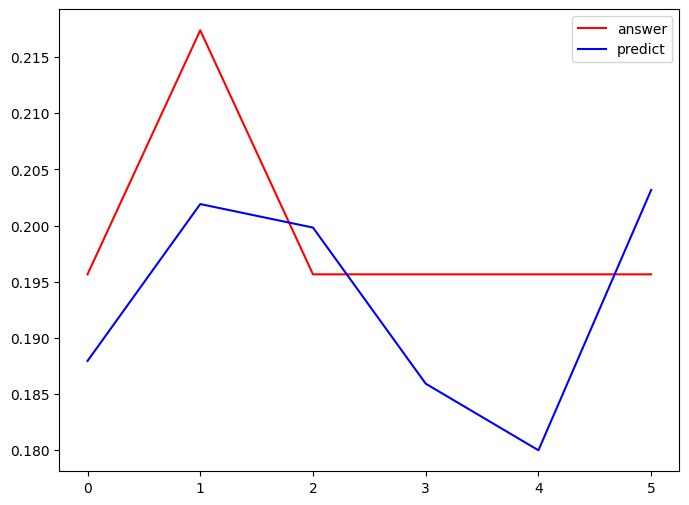

In [88]:
plt.plot(answer_list[4], color = 'r', label = 'answer')
plt.plot(predict_list[4CNN-LSTM.ipynb], color = 'b', label = 'predict')

plt.legend()
plt.show()

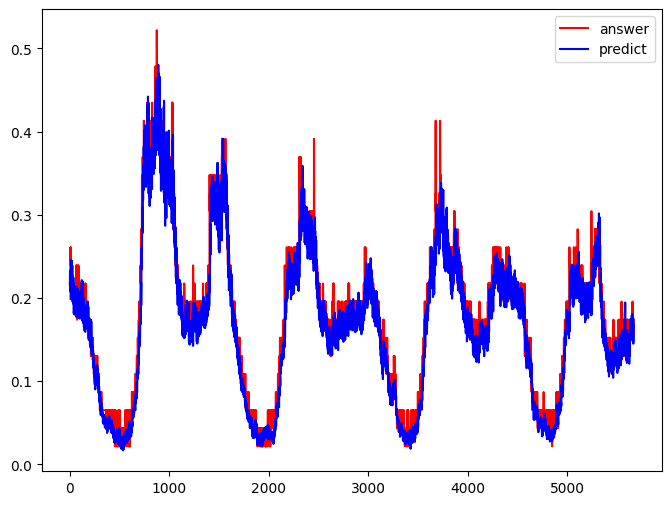

In [85]:
plt.plot(answer, color = 'r', label = 'answer')
plt.plot(predict, color = 'b', label = 'predict')

plt.legend()
plt.show()

In [86]:
a = answer
b = predict
from sklearn.metrics import mean_absolute_percentage_error
print(mae(a, b).numpy())
print(mse(a, b).numpy()) 
print(r2_score(a, b))
print(RMSE(a, b))
print(mean_absolute_percentage_error(answer, predict))

0.016787957
0.00049319805
0.940592546867408
0.022208063438378434
0.11761365338285501
